## Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, et. 

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the ﬁrst transaction of a new user is fraudulent.


## Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes. 

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists. 

You only have information about the user ﬁrst transaction on the site and based on that you have to make your classiﬁcation ("fraud/no fraud"). 

These are the tasks you are asked to do: 
1. For each user, determine her country based on the numeric IP address. 
2. Build a model to predict whether an activity is fraudulent or not. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is what kind of diﬀerent user experiences would you build based on the model output.

Information about table:
"Fraud_Data" - information about each user first transaction

"IpAddress_to_Country" - mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country.


In [51]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [31]:

Ip=pd.read_csv('IpAddress_to_Country.csv')
user=pd.read_csv('Fraud_Data.csv')

In [126]:
user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [31]:
Ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [36]:
Ip.groupby('country').groups

{'Afghanistan': Int64Index([  1920,   6205,   6435,  19022,  28696,  28701,  28836,  29234,
              29304,  29368,  29514,  29624,  29655,  29656,  29730,  30069,
              30136,  30480,  30634,  30857,  30900,  31015,  31078,  31341,
              31650,  31884,  34239,  34295,  35303,  35371,  35716,  36110,
              36136,  36822,  36983,  49110,  52959,  53164,  53480,  80828,
             112005, 112602, 119566, 119970, 132642, 132643],
            dtype='int64'),
 'Albania': Int64Index([  2165,   2340,   2542,   2785,   2973,   2975,   3340,   4702,
               5046,   5330,   5673,   5753,  13603,  13688,  14109,  14165,
              14353,  14646,  14684,  14841,  14859,  15503,  15970,  16773,
              19220,  21344,  23598,  24172,  25914,  26370,  26869,  27464,
              33153,  33173,  33367,  33817,  33854,  37595,  38951,  40482,
              41711,  51936,  54288,  54860,  55652,  55749,  55816,  56175,
              58105,  81711,  81712, 

In [32]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


## Data Explore Analysis

In [33]:
## There are no duplicates in the user dataset
len(user)==len(user['user_id'].unique())

True

In [32]:
## Add country column to the user dataset
countries = []
for i in range(len(user)):
    ip_address = user['ip_address'][i]
    tmp = Ip[(Ip['lower_bound_ip_address'] <= ip_address) &
                          (Ip['upper_bound_ip_address'] >= ip_address)]  ## return boolean False & True under lower/upper_bound ip address
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
user['country'] = countries

user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [48]:
user.country.describe()

count            151112
unique              182
top       United States
freq              58049
Name: country, dtype: object

In [55]:
user.groupby('country')['user_id'].count().sort_values(ascending=False)

country
United States                           58049
NA                                      21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                    

## Feature Engineering
A few obvious variables that can be created here could be: 
1. Time difference between sign-up time and purchase time 
2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts) Same for the ip address. 
3. Many different users having the same ip address could be an indicator of fake accounts 
4. Usual week of the year and day of the week from time variables


In [33]:
## Time difference
# it is very suspicious for a user signup and then immediately purchase
user['signup_time']=pd.to_datetime(user['signup_time'])
user['purchase_time']=pd.to_datetime(user['purchase_time'])
tdelta = (user['signup_time']-user['purchase_time']).dt.total_seconds()
user['tdelta'] = tdelta

In [66]:
#check if device id is unique
# the more a device is shared, the more suspicious
len(user['device_id'].unique())==len(user['user_id'])

False

In [34]:
device_num = user[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
##如果直接根据device_id left join 两个表的话,两个user_id名字重复,会有user_id_x,y;
##因此需要列名重命名
data = user.merge(device_num, how='left', on='device_id')

In [35]:
# Check user number for unique ip_address
# the more a ip is shared, the more suspicous
ip_num = user[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [107]:
same=sum(data['device_num']>1)
1-same/len(data)

0.8720750172057812

In [113]:
1-sum(data['ip_num']>1)/len(data)

0.9446767960188469

For 87.2%, one user match one device. 
94.5% users use same ip address when log in the website.

In [37]:
# #day of the week and day
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [38]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,tdelta,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,-4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,-17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,-1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,-492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,-4361461.0,1,1,1,30,2,37


In [11]:
data.isna().values.any()

False

In [39]:
df=data[['purchase_value','source','browser','sex','age','class','device_num','ip_num','signup_day','signup_week','purchase_day','purchase_week']]
df.head()

,purchase_value,source,browser,sex,age,class,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,34,SEO,Chrome,M,39,0,1,1,1,9,5,16
1,16,Ads,Chrome,F,53,0,1,1,6,23,0,24
2,15,SEO,Opera,M,53,1,12,12,3,1,3,1
3,44,SEO,Safari,M,41,0,1,1,1,18,0,19
4,39,Ads,Safari,M,45,0,1,1,1,30,2,37


In [40]:
## Label Encoding
lb_make = LabelEncoder()
df['source'] = lb_make.fit_transform(df['source'])
df['browser'] = lb_make.fit_transform(df['browser'])
df['sex'] = lb_make.fit_transform(df['sex'])

C:\Users\blanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\blanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\blanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [41]:
df.head()

,purchase_value,source,browser,sex,age,class,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,34,2,0,1,39,0,1,1,1,9,5,16
1,16,0,0,0,53,0,1,1,6,23,0,24
2,15,2,3,1,53,1,12,12,3,1,3,1
3,44,2,4,1,41,0,1,1,1,18,0,19
4,39,0,4,1,45,0,1,1,1,30,2,37


## Build logistic regression model

In [44]:
y=df['class']
X=df.copy().drop(['class'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.95


## Cofunsion Matrix

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[44988   243]
 [ 2175  2461]]


The result is telling us that we have 44988+2461 correct predictions and 2175+243 incorrect predictions.

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.95      0.99      0.97     45231
          1       0.91      0.53      0.67      4636

avg / total       0.95      0.95      0.95     49867



Of the entire test set, 95% of the ﬁrst transaction of a new user is not 
fraudulent.

## ROC Curve

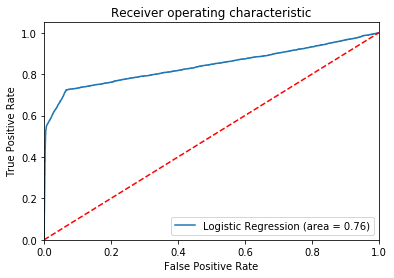

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

####  Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.
Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of 0.55 and false positive rate almost zero (this was essentially the logistic regression output). However, if we care about maximizing true positive, we will have to decrease the cut-off. When the true positive goes up, unfortunately, false positive will also go up. This means we will classify more events as “1”. 

### Insights:  
#### What kinds of users are more likely to be classiﬁed as at risk? 
#### What are their characteristics?

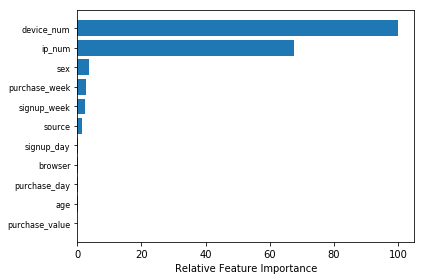

In [58]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()   
plt.show()

The number of users using the same device is the most important feature to predict the fraud trasaction. Also, the number of users using the same ip could be an indicator of fake accountsthe. 

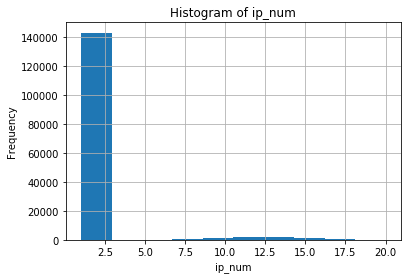

In [83]:
df.ip_num.hist()
plt.title('Histogram of ip_num')
plt.xlabel('ip_num')
plt.ylabel('Frequency')
plt.savefig('hist_ip_num')

From the histgram, most users have unique ip address.

In [77]:
result=df['class'].groupby([df['ip_num']]).mean()

Text(0,0.5,'Fraud Rate')

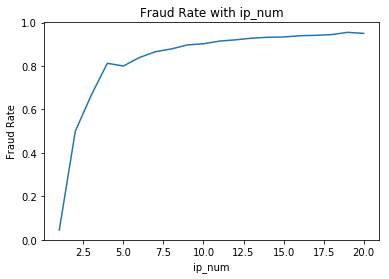

In [81]:
result.plot(kind='line')
plt.title('Fraud Rate with ip_num')
plt.xlabel('ip_num')
plt.ylabel('Fraud Rate')

Text(0,0.5,'Fraud Rate')

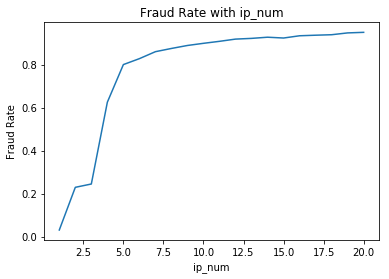

In [84]:
result1=df['class'].groupby([df['device_num']]).mean()
result1.plot(kind='line')
plt.title('Fraud Rate with ip_num')
plt.xlabel('ip_num')
plt.ylabel('Fraud Rate')

From the plots, we can get the conclusion that many different user ids using the same the ip address or device have a higher likelihood of fraud.

###  From a product perspective, how would you use this model? 

We now have a model that assigns to each user a probability of committing a fraud. We want to think about creating different experiences based on that. 

For instance: 
1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here) 
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook. 
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed. 

